In [19]:
import keras
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
#from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

# Open the MA_AIZP stock file from the _Rolling dir
TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data\\_Rolling"
df = pd.read_csv(f"{TICKER_DIR}\\MA_AIZP.csv", header=0)

# Our target is the close price of the stock
target = df["close"].tail(180)
dataset = df[["high", "low", "open"]].tail(180)

In [20]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		end_ix = i + n_steps
		if end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

n_steps = 3

high = dataset["high"].values.reshape(len(dataset), 1)
low = dataset["low"].values.reshape(len(dataset), 1)
open = dataset["open"].values.reshape(len(dataset), 1)
close = target.values.reshape(len(dataset), 1)

# stack them horizontally
d = np.hstack((open, high, low, close))
# split sequences
X, y = split_sequences(d, n_steps)

n_features = X.shape[2]
print(d.shape)
print(X.shape)
print(y.shape)

(180, 4)
(178, 3, 4)
(178, 4)


In [36]:
# clears previous sessions
keras.backend.clear_session()
# create a Sequential model
model = Sequential()
# 2 LSTM layers, 100 nodes each
model.add(LSTM(100, activation="relu", return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation="relu"))
# 1 fully connected layer
model.add(Dense(n_features))
# set learning rate to 0.001
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss="mae", metrics=["accuracy", "mae", "mse"])

# split dataset to training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

model.fit(X_train, y_train, epochs=500, verbose=1)

82 - accuracy: 0.7042 - mae: 0.5382 - mse: 0.4551
Epoch 351/500
142/142 [==============================] - 0s 218us/step - loss: 0.5917 - accuracy: 0.7113 - mae: 0.5917 - mse: 0.5526
Epoch 352/500
142/142 [==============================] - 0s 232us/step - loss: 0.7998 - accuracy: 0.6901 - mae: 0.7998 - mse: 0.8740
Epoch 353/500
142/142 [==============================] - 0s 208us/step - loss: 0.6316 - accuracy: 0.6690 - mae: 0.6316 - mse: 0.6034
Epoch 354/500
142/142 [==============================] - 0s 218us/step - loss: 0.7071 - accuracy: 0.3732 - mae: 0.7071 - mse: 0.7343
Epoch 355/500
142/142 [==============================] - 0s 204us/step - loss: 0.5719 - accuracy: 0.6901 - mae: 0.5719 - mse: 0.5302
Epoch 356/500
142/142 [==============================] - 0s 201us/step - loss: 0.5341 - accuracy: 0.3239 - mae: 0.5341 - mse: 0.4768
Epoch 357/500
142/142 [==============================] - 0s 201us/step - loss: 0.5585 - accuracy: 0.5070 - mae: 0.5585 - mse: 0.5144
Epoch 358/500
142/1

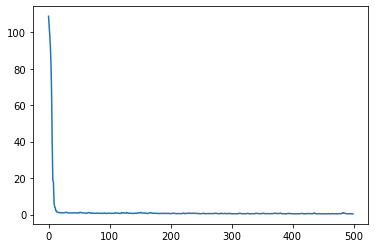

In [37]:
# plot the models loss history
model.history.history.keys()
plt.plot(model.history.history["loss"])

In [38]:
# evaluate the model with the testing datasets
scores = model.evaluate(X_test, y_test, verbose=0)
print(*[f"History Item [{item}] reports value of {value}" for value, item in zip(scores, model.metrics_names)], sep="\n")

History Item [loss] reports value of 0.5310915311177572
History Item [accuracy] reports value of 0.6111111044883728
History Item [mae] reports value of 0.5310915112495422
History Item [mse] reports value of 0.3865584135055542


In [39]:
# take the last 36 close values for testing
# 36 is the size of the testing set
actual = df["close"].tail(36).values
yhat = model.predict(X_test, verbose=0)
predictions = yhat[:, -1]

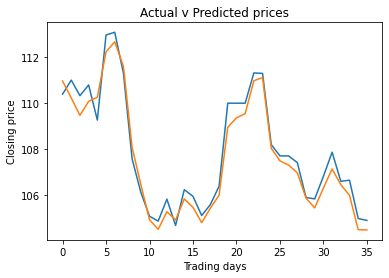

In [41]:
# plot the predicted values against the actual values
fig = plt.figure()
plt.title("Actual v Predicted prices")
plt.ylabel("Closing price")
plt.xlabel("Trading days")
plt.plot(actual)
plt.plot(predictions)
plt.savefig("C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\AIZP.png")